In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# building the vocanulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# building the dataset

block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


tensor(-0.0077) tensor(1.0056)
tensor(-0.0018) tensor(3.1753)


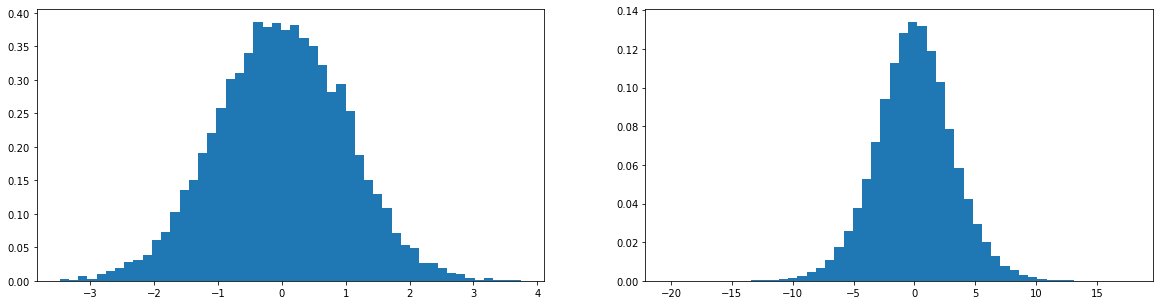

In [6]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

we want standard deviation of both of these to be somewhat close to 1, hence when defining weights tensor since passes through the tanh non linearity afterwards need to multiply by

Standard deviation = gain / fen_in

gain is defined for each non_linearity, for tanh = 5/3
fen_in = ((n_embed * block_size) ** 0.5)
that's it

tensor(-0.0077) tensor(1.0001)
tensor(-0.0017) tensor(1.6525)


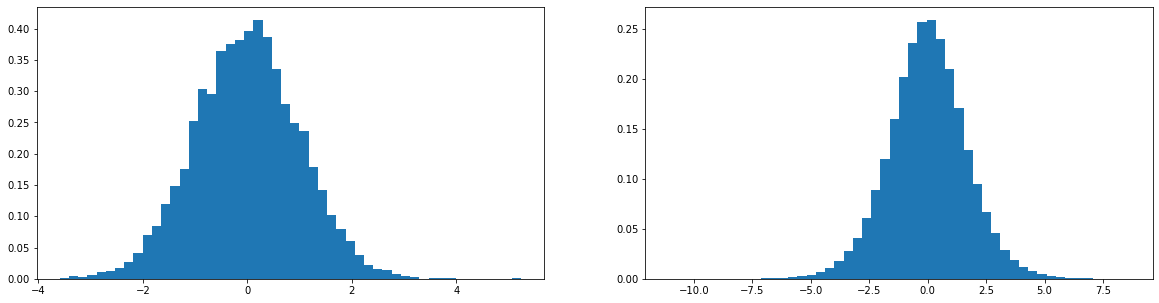

In [7]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * (5/3)/ 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

right now it is not that used bcz of batch normalization, just making hidden layers as **unit** gaussian in starting and scaled and shifted version after that

so x = (x-mean)/std, will do with hpreact, need to take 2 more parameters for scaling and shifting, initially ones and zeros respectively. scaling->gain, shifing->bias. And both of these will be trained too.

batch normalization also act as a regularizer as these parameters will train on diff batches and affect other batches training also, hence other normalizations were also introduced.

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character of embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator = g) # might be placing a lot of characters in 2d space, hence increasing to 10
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size)**0.5)        #3 2 dimensional vectors being fed as i/p
b1 = torch.randn(n_hidden,                         generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01  # making W2 smaller to get logits closer to zero, also uniformly dsitributed.
b2 = torch.randn(vocab_size,                      generator = g) * 0    # for making logits close to 0, don't want to add bias


bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total parameters in the n/w
for p in parameters:
    p.requires_grad = True

12297


In [7]:
C.shape, len(C)

(torch.Size([27, 10]), 27)

In [8]:
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # Forward pass
    emb = C[Xb] # embedding characters into vectors, can pass a list as well to get embedding of each character
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors, -1 tells torch to figure out the next shape itself and alter the vector emb accordingly.
    
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    
    # BatchNorm layer
    # -------------------------------------------------#
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------#
    
    # non linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function(cross entropy calculates prob and stuff itself, just need to pass it 'y'(pred), and original)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10 == 0: # print every once in a while (at every 10000th step)
        print(f'{i:3d}/{max_steps:3d}: {loss.item():.4f}') # here 3d tells how many places to reserve for 'i', and .4f, how many digits to show after '.'
    lossi.append(loss.log10().item())
    

  0/10000: 3.3147
 10/10000: 3.0830
 20/10000: 3.0096
 30/10000: 3.0178
 40/10000: 3.0603
 50/10000: 2.7722
 60/10000: 2.6871
 70/10000: 2.9440
 80/10000: 2.7026
 90/10000: 2.4555
100/10000: 2.4222
110/10000: 2.8650
120/10000: 2.5153
130/10000: 2.5097
140/10000: 2.8835
150/10000: 2.4766
160/10000: 2.8445
170/10000: 3.0632
180/10000: 2.6741
190/10000: 2.6397
200/10000: 2.8362
210/10000: 2.7168
220/10000: 2.5119
230/10000: 2.7638
240/10000: 2.7194
250/10000: 2.4495
260/10000: 2.5519
270/10000: 2.4896
280/10000: 2.5770
290/10000: 2.6794
300/10000: 2.5838
310/10000: 2.5402
320/10000: 2.2332
330/10000: 2.7264
340/10000: 2.4355
350/10000: 2.7890
360/10000: 2.6253
370/10000: 2.5314
380/10000: 2.6095
390/10000: 2.3302
400/10000: 2.5099
410/10000: 2.8110
420/10000: 2.7162
430/10000: 2.8313
440/10000: 2.5877
450/10000: 2.5466
460/10000: 2.5752
470/10000: 2.1902
480/10000: 2.5626
490/10000: 2.3326
500/10000: 2.7987
510/10000: 2.8277
520/10000: 2.7929
530/10000: 2.8884
540/10000: 2.2588
550/10000:

4400/10000: 2.1537
4410/10000: 2.3973
4420/10000: 2.5311
4430/10000: 2.4532
4440/10000: 2.4907
4450/10000: 2.3313
4460/10000: 2.5146
4470/10000: 1.8384
4480/10000: 2.2051
4490/10000: 2.2962
4500/10000: 2.0753
4510/10000: 2.3020
4520/10000: 2.1203
4530/10000: 2.1681
4540/10000: 2.6099
4550/10000: 2.2651
4560/10000: 2.5760
4570/10000: 2.3383
4580/10000: 2.6308
4590/10000: 2.4190
4600/10000: 2.1254
4610/10000: 2.4229
4620/10000: 2.2417
4630/10000: 2.4944
4640/10000: 2.5813
4650/10000: 2.3237
4660/10000: 2.1342
4670/10000: 2.6170
4680/10000: 2.5532
4690/10000: 2.0663
4700/10000: 2.1426
4710/10000: 2.2828
4720/10000: 2.2602
4730/10000: 2.2165
4740/10000: 2.4009
4750/10000: 2.1552
4760/10000: 2.3632
4770/10000: 2.4084
4780/10000: 2.4049
4790/10000: 2.7155
4800/10000: 2.2359
4810/10000: 2.5200
4820/10000: 2.1066
4830/10000: 2.2248
4840/10000: 2.3967
4850/10000: 2.8789
4860/10000: 2.1148
4870/10000: 2.3809
4880/10000: 2.2135
4890/10000: 2.2988
4900/10000: 2.5007
4910/10000: 2.4908
4920/10000: 

8740/10000: 2.6931
8750/10000: 2.4300
8760/10000: 2.6956
8770/10000: 2.4445
8780/10000: 1.7530
8790/10000: 2.0875
8800/10000: 2.2002
8810/10000: 2.0752
8820/10000: 2.0999
8830/10000: 2.3748
8840/10000: 2.3909
8850/10000: 2.2870
8860/10000: 2.3746
8870/10000: 2.6785
8880/10000: 1.9551
8890/10000: 2.5067
8900/10000: 2.3509
8910/10000: 2.4389
8920/10000: 1.8916
8930/10000: 2.2170
8940/10000: 2.3762
8950/10000: 1.9400
8960/10000: 2.0111
8970/10000: 2.2732
8980/10000: 2.0811
8990/10000: 2.6486
9000/10000: 2.2276
9010/10000: 2.1107
9020/10000: 2.3711
9030/10000: 2.0134
9040/10000: 2.1375
9050/10000: 2.4797
9060/10000: 2.2724
9070/10000: 2.2395
9080/10000: 2.1974
9090/10000: 2.5637
9100/10000: 2.0818
9110/10000: 2.0817
9120/10000: 2.2192
9130/10000: 2.0797
9140/10000: 2.4864
9150/10000: 2.2003
9160/10000: 2.5139
9170/10000: 2.1939
9180/10000: 2.1038
9190/10000: 3.0350
9200/10000: 1.9755
9210/10000: 2.7574
9220/10000: 2.1331
9230/10000: 2.8300
9240/10000: 2.3149
9250/10000: 2.4662
9260/10000: 

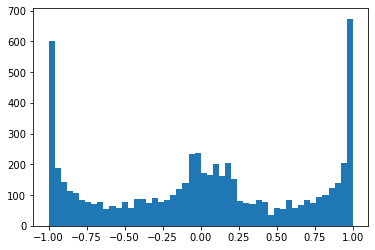

In [14]:
plt.hist(h.view(-1).tolist(), 50); # most of the values 1 and -1 if  W1 and b1 not nultiplied by 0.1 and 0.01

##### if h which is the tensor received after tanh operation return 1 or -1 and most of the times, it will create problem in backpropagation. 

##### x = self.data
##### t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
##### t = tanh(x) = 1 or -1 here
##### self.grad += (1 - t^2) * out.grad
##### basically self.grad becomes zero here and all the info how it is affecting loss is gone.

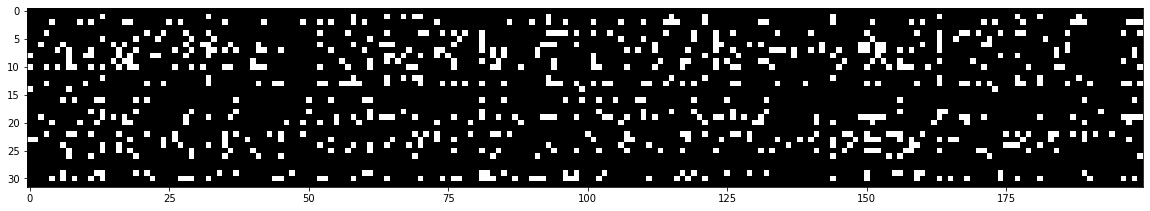

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # current fig after training the whole n/w

In [16]:
h.shape

torch.Size([32, 200])

### x-axis representing 200 neurons, and h value if 1 ie white area, if the whole column is white, this would mean it's a dead neuron as not able to learn anything from any example ie that neuron is always giving 1 or -1 i.e not helping in learning.

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50); # after altering W1 and b1, could change and run again

In [ ]:
# torch.tanh(torch.tensor(2.5)) most of the values causing 1 or -1. so need to squash hpreact.

In [ ]:
logits[0]

if scrutinize:

initialization is not good, initially prob of any character following the context is equal = 1/27, uniform distribution
network is confidently wrong initially, confident of some characters to be 'y' and some has even less probability of occuring than 1/27.0 and predicts the worng ones

In [ ]:
# # 4-dimensional example of the issue occuring above:
# logits = torch.tensor([0.0, 5.0, 0.0, 0.0]) # assigning higher count to 2nd index -> 3rd class
# probs = torch.softmax(logits, dim=0) # 2nd index having higher prob
# loss = -probs[2].log() # assigning 0 count to logits[2], hence prob low and loss high., what if everyone has some value except at index 2, loss will shoot up

# probs, loss 

In [ ]:
# what initial loss should have been
-torch.tensor(1/27.0).log()

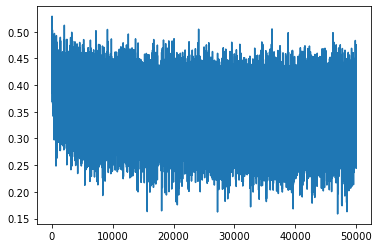

In [34]:
plt.plot(lossi)

In [9]:
# while in use practically just predicts on a single input x, doesn't require a batch so need to do some changes

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    
# calculated the mean and std of the whole dataset but why to calculate explicitly, just calculate on the go while training.

In [23]:
@torch.no_grad() # this decorator disabless gradient tarcking
def split_loss(split):
    x, y = {
        'train' : {Xtr, Ytr},
        'val' : {Xdev, Ydev},
        'test' : {Xte, Yte},
    }[split]
    
    emb = C[x] #(N, block_size, n_embd(10))
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # used the whole Xtr mean and std for a single X here 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.161442518234253
val 2.190159559249878


In [10]:
# samnple from the model

g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    
    out = []
    context = [0] * block_size # contains index of each alpha initially '...'
    while True:
        emb = C[torch.tensor([context])] #(1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

munjded.
luckarhullfargellan.
jhirltohskashriz.
braxnaduvandlevanckdbdeilrwammidsnis.
baylantellaruummryf.
dtumjrngynslewhryann.
jora.
brengcklynn.
brie.
brmoknmwynslevgansnrsslimanszahddgonfmidangel.
mrremmarthmtrrynr.
lu.
marmonrr.
mmekummbahvinghan.
vavckyarruwdrh.
frrith.
malyns.
mlah.
givellaponb.
zhamirvellan.


In [28]:
                                            ######## SUMMARY #########

In [59]:
# training a deeper n/w

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True): # fan_in = input_features, similarly out
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out)
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1): # dim = num of features of input
        self.eps = eps
        self.momentum = momentum
        self.Training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.Training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True)
        else: # while giving the single input while testing(not training)
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.Training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embed = 10 # the dimension of the character embedding vectors
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),                   generator = g)

# list of layers required in MLP
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),                  # so Linear has already been initialized here
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    # last layer: make less confident (as seen above)
    # since last layer has been updated to batchnorm1d, wont be changing the last layers's weight instead the factor gamma which multiplicatively interacts with the output of that normalization
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # since using tanh
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total parameters
for p in parameters:
    p.requires_grad = True

47551


In [70]:
max_steps =  20000
batch_size = 32
lossi = []
ud = [] # update data store

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x) # Linear was already initialized above now calling only to get Y of that layer and stored in x
    loss = F.cross_entropy(x, Yb) # comparing final logits and Yb
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # after_debug: would take out retain_graph whatever each linear layer return, retain their grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%1000 == 0:
        print(f'{i:5d}/{max_steps:5d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    

    0/20000: 3.2839
 1000/20000: 2.4690
 2000/20000: 2.5112
 3000/20000: 2.1471
 4000/20000: 2.0779
 5000/20000: 2.3618
 6000/20000: 2.3989
 7000/20000: 2.1140
 8000/20000: 2.3418
 9000/20000: 2.1545
10000/20000: 2.5041
11000/20000: 2.0990
12000/20000: 2.1163
13000/20000: 2.1891
14000/20000: 2.0795
15000/20000: 2.0413
16000/20000: 2.0558
17000/20000: 2.3382
18000/20000: 2.1351
19000/20000: 2.2669


layer 2 {      Tanh}: mean -0.00, std 0.63, saturated: 4.09%
layer 5 {      Tanh}: mean -0.02, std 0.66, saturated: 4.50%
layer 8 {      Tanh}: mean -0.01, std 0.66, saturated: 4.41%
layer 11 {      Tanh}: mean +0.01, std 0.67, saturated: 3.62%
layer 14 {      Tanh}: mean -0.00, std 0.68, saturated: 3.41%


Text(0.5, 1.0, 'activation distribution')

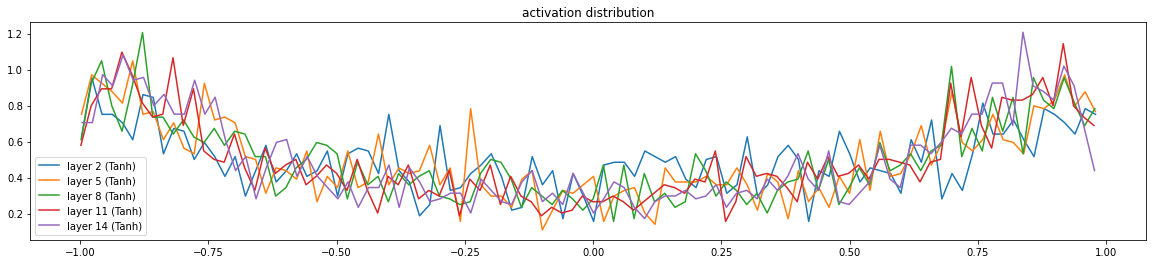

In [71]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d {%10s}: mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

#### the reason they give such a nice distribution is bcz the gain is set to 5/3 (some gain is required to deal with squashing done by tanh), can play with it.

layer 2 {      Tanh}: mean -0.000000, std 4.607406e-03
layer 5 {      Tanh}: mean +0.000000, std 4.423981e-03
layer 8 {      Tanh}: mean +0.000000, std 4.362992e-03
layer 11 {      Tanh}: mean -0.000000, std 4.110197e-03
layer 14 {      Tanh}: mean -0.000000, std 3.850005e-03


Text(0.5, 1.0, 'activation distribution')

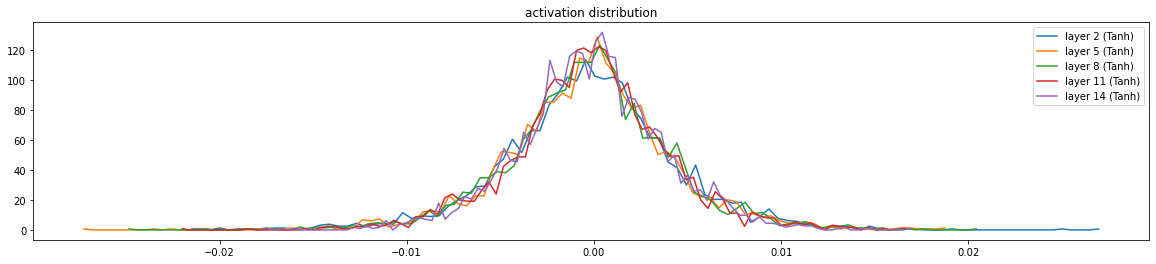

In [72]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d {%10s}: mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 1.382201e-02 | grad:data ratio 1.373912e-02
weight  (30, 100) | mean +0.000181 | std 1.172158e-02 | grad:data ratio 3.638365e-02
weight (100, 100) | mean +0.000064 | std 8.970358e-03 | grad:data ratio 5.037662e-02
weight (100, 100) | mean -0.000010 | std 8.532441e-03 | grad:data ratio 4.809756e-02
weight (100, 100) | mean -0.000015 | std 8.306255e-03 | grad:data ratio 4.723897e-02
weight (100, 100) | mean +0.000064 | std 7.541749e-03 | grad:data ratio 4.314260e-02
weight  (100, 27) | mean +0.000338 | std 1.404265e-02 | grad:data ratio 7.317156e-02


Text(0.5, 1.0, 'weight gradient distrubution')

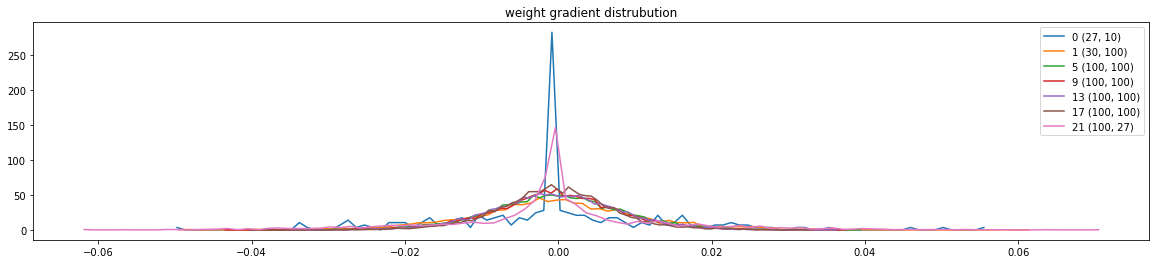

In [73]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distrubution')

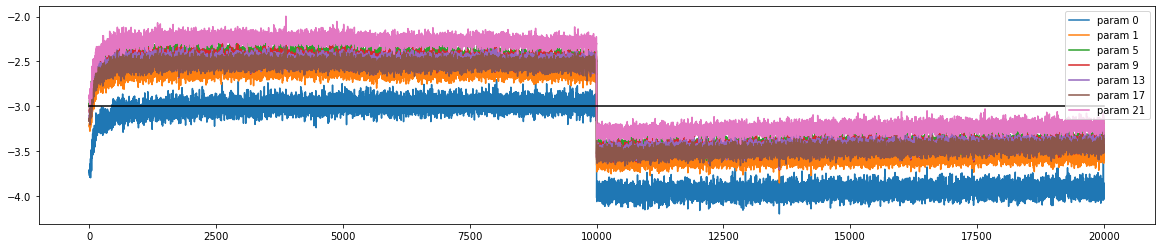

In [74]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)